<a href="https://colab.research.google.com/github/UMassIonTrappers/quantum-computing-labs/blob/main/labs/Lab_10_Grover_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 550/650

## Introduction to Quantum Computing

Robert Niffenegger (rniffenegger@umass.edu )

In [1]:
try:
  import qiskit
except ImportError:
  print('Install Qiskit')
  !pip install --quiet qiskit
  !pip install --quiet qiskit[visualization]
  !pip install --quiet git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

try:
  from qiskit_aer import QasmSimulator
  print('Qiskit Aer imported');
except ImportError:
  print('Install Qiskit-Aer')
  !pip install --quiet qiskit-aer

  
try:
  from qiskit_ibm_runtime import QiskitRuntimeService
  print('Qiskit-IBM-Runtime imported')

except ImportError:
  print('Install Qiskit-IBM-Runtime')
  !pip install --quiet qiskit-ibm-runtime
  !pip install --quiet qiskit_ibm_provider[visualization]


Qiskit Aer imported
Qiskit-IBM-Runtime imported


# Initialize and import

In [2]:
from IPython.display import display, Math, Image
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos
import math
import time

#Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

#Qisket imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city, plot_state_hinton
from qiskit.visualization import array_to_latex
from qiskit.visualization import *

from qiskit_aer import QasmSimulator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error, pauli_error

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

from qiskit.circuit.library import *
from qiskit.circuit.library import GroverOperator
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector, Operator



In [3]:
token = "INSERT YOUR TOKEN HERE"

# https://quantum.ibm.com/
if token == "INSERT YOUR TOKEN HERE":
    token = input("Please enter your IBM Quantum token: ")

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True,
  set_as_default=True
)

In [5]:
QasmSim = QasmSimulator() #Set simulator to evolve state

def ideal_sim(qc,shots=100):
    job = QasmSim.run(qc, shots=shots)
    result = job.result()
    count = result.get_counts()
    return count


# Grover Search (Amplitude Amplification)

You have likely heard that one of the many advantages a quantum computer has over a classical computer is its superior speed searching databases.
This is often described as being able to search *all* entries simultaneously. 

We'll see this isn't exactly true but more that with *iterative* steps we can consisitently hone in on the answer out of many, amplifying it's chance of being measured.

The Grover Search algorithm can in principle use this to search large datasets in an efficient way that has some possible *quadratic* speedup relative to classical computers.

To locate a specified item from a list of many items, a classical computer must examine each element until the solution is located.
For a set of N items, this takes, on average, N/2 searches, $\mathcal{O}(N/2)$.

A quantum computer using a Grover search can provide arbitrarily confident guesses for the location of the desired item depending on the number of times the algorithm is performed. 
Typically the average number of required searches is $\sqrt{N}$ , which has been proven to be the fastest speedup possible for this problem (Bennett, 1997).

So therefore based on query complexity the quantum algorithm $\mathcal{O}(\sqrt{N})$ is faster than the classical algorithm $\mathcal{O}(N/2)$, thus a quadratic speed up.


----

More generally there are a class of quantum algorithms that can use part of Grover's algorithm as a general trick or subroutine to obtain quadratic run time improvements for a variety of other algorithms. This is called  **amplitude amplification** and is related to a number of 'quantum walk' algorithms described in more detail by Andrew Childs in their notes (https://www.cs.umd.edu/~amchilds/qa/qa.pdf).


References:
* https://www.cs.umd.edu/~amchilds/qa/
* https://qiskit.org/textbook/ch-algorithms/grover.html
* https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb
* Thomas Wong's book - 7.6 Brute-Force Searching

Let's see how it works:

# 1. Create a superposition state $|++++\rangle=|s\rangle$

1. Create n qubit register
1. Apply Hadamard Gates to put every qubit in a perfect superposition state $|+⟩_x = \frac{|0⟩ + |1⟩}{\sqrt{2}}$

Then measure just to see what we have so far.

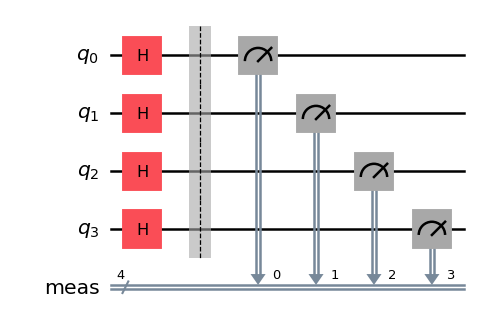

In [6]:
n = 4 #Number of qubits
qc = QuantumCircuit(n)

for i in range(n):
    qc.h(i) #Hadmards for each input state

qc.measure_all()

qc.draw('mpl', scale = 0.9)

Applying Hadamard gates to each qubit creates the uniform superposition state |s⟩

Here is an image from the QisKit textbook to help represent the algorithm.

The state |w⟩ represents the solution, and |s⟩ is the equal superposition state . |s'⟩ therefore is an arbitrary state that it is orthogonal to |w⟩, making it the state of all the incorrect states.

The search will allow us to test all of these superposition states in |s⟩ **simultaneously** to see if they are the 'correct' answer |w⟩. However, this process is iterative and equivalent to rotating the vector closer to |w⟩ and farther from |s'⟩


Let's arbitrarily define the answer as |w⟩= 12


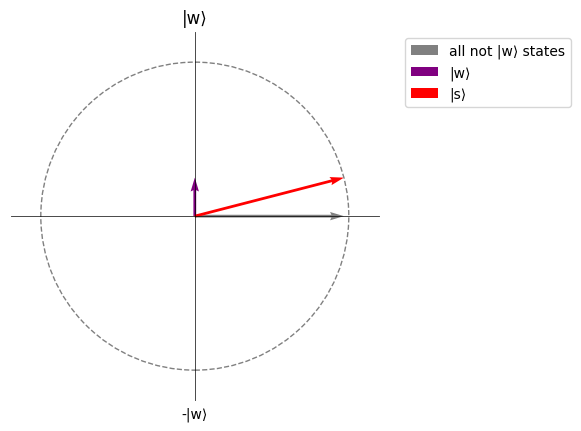

In [7]:
mag = n**2

# Plot the vector components
plt.quiver(0, 0, np.sqrt((n**2-1)/n**2), 0, angles='xy', scale_units='xy', scale=1, color='grey', label='all not |w⟩ states')
plt.quiver(0, 0, 0, np.sqrt(1/n**2), angles='xy', scale_units='xy', scale=1, color='purple', label='|w⟩')

# Plot the full vector
plt.quiver(0, 0, np.sqrt((n**2-1)/n**2), np.sqrt(1/n**2), angles='xy', scale_units='xy', scale=1, color='red', label='|s⟩')

def format_plot():
    # Set equal aspect ratio and limits
    plt.gca().set_aspect('equal')
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    
    # Add unit circle
    circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--')
    plt.gca().add_artist(circle)

    # Add axis lines
    plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)

    # Set frame color to white and remove ticks
    plt.gca().spines['top'].set_color('white')
    plt.gca().spines['bottom'].set_color('white') 
    plt.gca().spines['left'].set_color('white')
    plt.gca().spines['right'].set_color('white')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

    plt.xlabel('-|w⟩')
    plt.ylabel('')
    plt.title('|w⟩')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

format_plot()


The angle will be $\theta = \arcsin(1/\sqrt{N}) = \arcsin(1/4)\approx 15 \deg$

We can verify we have created an equal superposition state by simulating the circuit.

Counts for state |12>: 106


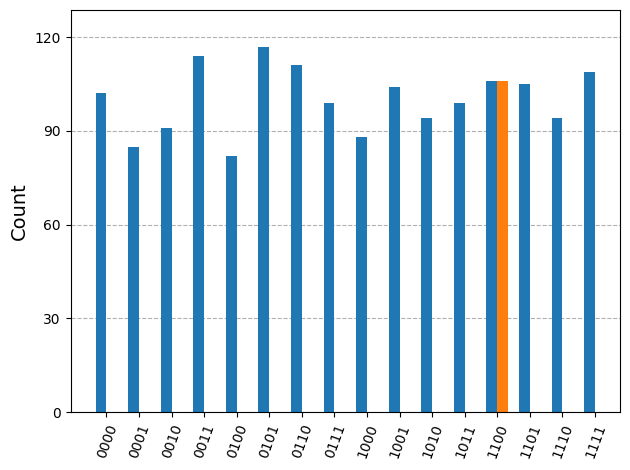

In [8]:
# Configure simulation engine
QasmSim = QasmSimulator() #Set simulator to evolve state

n_shots = (2**n)*100 #100 trials per bit string

job_sim = QasmSim.run(qc, shots=n_shots)

result_sim = job_sim.result()
counts = result_sim.get_counts(qc)

# Create new counts dict with just state |12>
w_counts = {'1100': counts.get('1100', 0)}  # 12 in binary is 1100
print(f"Counts for state |12>: {w_counts['1100']}")

# Plot results
plot_histogram([counts, w_counts],bar_labels=False)

State initilized $\checkmark$

All of the states have a equal amplitude (up to projection noise).

We have no way to know which one is the correct solution and which is incorrect.

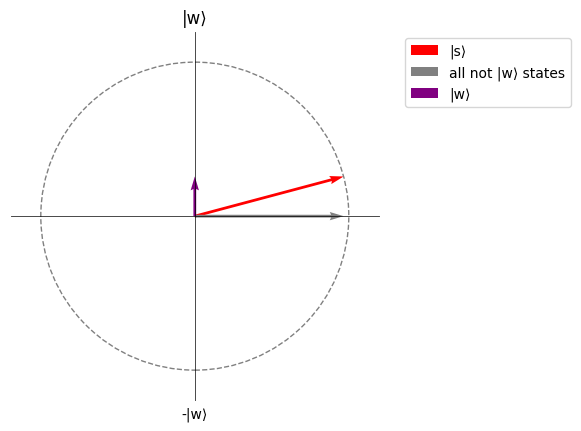

In [10]:
n=4
mag = n**2*100

y = list(w_counts.values())[0]  
x_comp = np.sqrt((mag-y)/mag)
y_comp = np.sqrt(y/mag)

# Plot main vector
plt.quiver(0, 0, x_comp, y_comp, angles='xy', scale_units='xy', scale=1, color='red', label='|s⟩')

plt.quiver(0, 0, x_comp, 0, angles='xy', scale_units='xy', scale=1, color='grey', label='all not |w⟩ states')
plt.quiver(0, 0, 0, y_comp, angles='xy', scale_units='xy', scale=1, color='purple', label='|w⟩')

format_plot()


# Step 2: Apply the Oracle

Now we can apply the "oracle". This is a circuit which acts on all qubits and flags the correct solution to the search. 

One of the exercises will show how you can construct this gate as a set of tests, checks, or logical clauses, using the rules of Sudoku as an example.

However, as a first trivial example we can modify an identity matrix by flipping a single entry negative to represent the correct solution.

> Further, the main exercise of this lab will have you constuct a logical check oracle based on the rules of Sudoko.*

It is instructive to note that the encoded 'solution' could also represent the configuration of the permuted bits and not just an integer as we will use.
It is also important to note that multiple configurations can be designated as solutions, which in this example would mean multiple integers.


___

We're expecting that the w component of the vector will be inverted. 


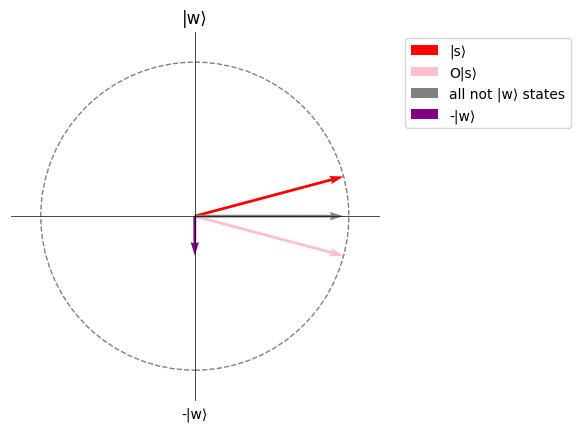

In [11]:
# Calculate vector components starting from right (x-axis)
n=4
mag = n**2*100

y = list(w_counts.values())[0]  
plt.quiver(0, 0, np.sqrt((mag-y)/mag), np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='red', label='|s⟩')
plt.quiver(0, 0, np.sqrt((mag-y)/mag), -np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='pink', label=r'O|s⟩')

plt.quiver(0, 0, np.sqrt((mag-y)/mag), 0, angles='xy', scale_units='xy', scale=1, color='grey', label='all not |w⟩ states')
plt.quiver(0, 0, 0, -np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='purple', label='-|w⟩')

format_plot()


After applying the oracle we have flipped the register's state about |s'⟩ in the 2 dimensional state space. This means the probability amplitude of |w⟩ is reflected about 0, while all other states are raised slightly in response.

To create this operation:

In [12]:
def create_oracle(n_qubits: int, solution: int) -> QuantumCircuit:
    '''
    Creates an oracle gate for Grover's algorithm that marks a specific solution state
    
    Args:
        n_qubits: Number of qubits in the circuit
        solution: Integer representing the marked solution state
        
    Returns:
        Oracle gate as a QuantumCircuit object
    '''
    # Print info about the register size and solution
    print('Max of', n_qubits, 'qubit register =', 2**n_qubits-1)
    
    binarystring = format(solution, "b") 
    print('Solution=', int(binarystring,2))
    print('Binary String of solution =', binarystring)

    # Create oracle matrix - identity with negative entry at solution
    matrix = np.identity(2**n_qubits, complex)
    matrix[solution, solution] *= -1

    # Convert matrix to quantum gate
    controls = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(controls)
    gate = Operator(matrix)
    circuit.unitary(gate, range(0, n_qubits))
    
    # Create named oracle gate
    Oracle = circuit.to_gate()
    Oracle.name = 'Oracle'
    
    return Oracle

# Create 4-qubit oracle marking state |12⟩
Oracle = create_oracle(n_qubits=4, solution=12)


Max of 4 qubit register = 15
Solution= 12
Binary String of solution = 1100


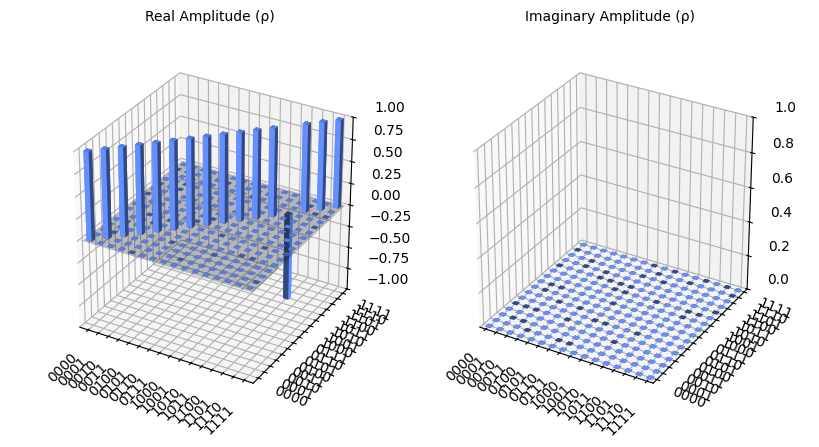

In [13]:
#Plot the Oracle matrix
n_qubits = 4
solution = 12
matrix = np.identity(2**n_qubits, complex)
matrix[solution, solution] *= -1

plot_state_city(matrix,figsize=(8,5))

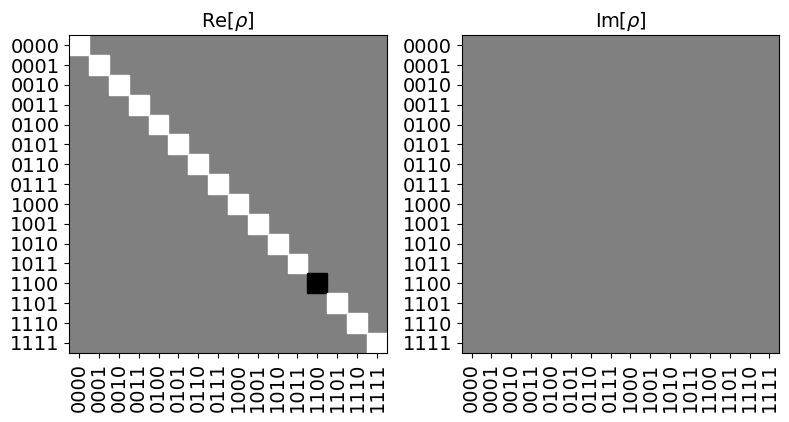

In [14]:
#Plot the Oracle matrix as a 'Hinton' plot
plot_state_hinton(matrix)

Apply oracle to the circuit

Max of 4 qubit register = 15
Solution= 12
Binary String of solution = 1100


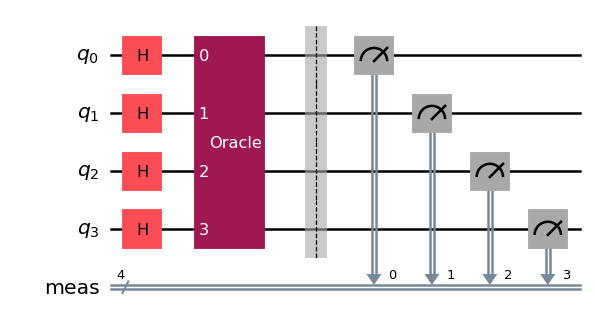

In [15]:
n = 4 # Number of qubits

#declare new circuit with N qubits
quantum_circuit = QuantumCircuit(n)

# Add Hadamard gates to each qubit
for i in range(n):
    quantum_circuit.h(i)

# Add the Oracle gate
Oracle = create_oracle(n_qubits=4, solution=12)
quantum_circuit.append(Oracle, range(n))

# Measurements
quantum_circuit.measure_all()

#Draw
quantum_circuit.draw('mpl', scale = 0.9)

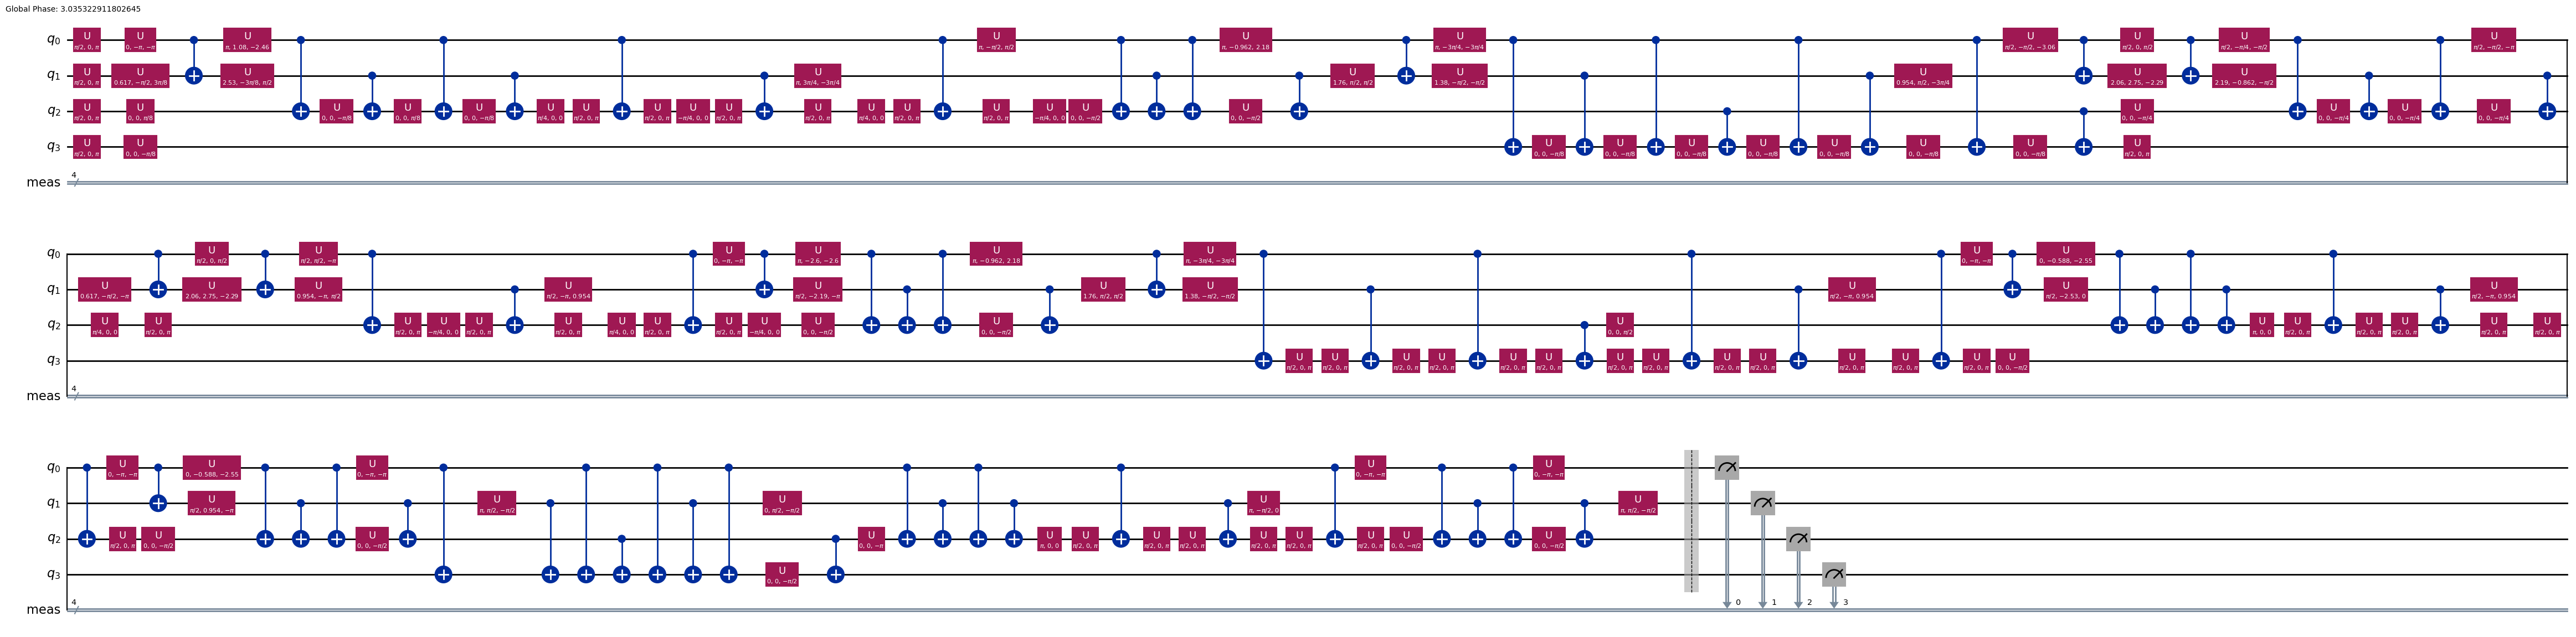

In [16]:
quantum_circuit.decompose().decompose().decompose().draw('mpl', fold = 70)

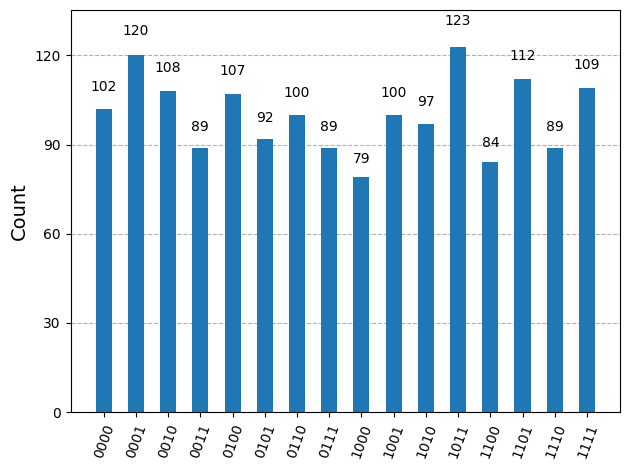

In [17]:
QasmSim = QasmSimulator() 
n_shots = (2**n)*100
job_sim = QasmSim.run(quantum_circuit.decompose(), shots=n_shots)
result_sim = job_sim.result()
counts = result_sim.get_counts(quantum_circuit)

plot_histogram(counts)

### All the probabilities are still the same!?!?

YES! We have applied a phase flip to the solution state... BUT we have not changed it's probability yet! Therefore the measurements will still be all in a superposition!

To see the phase of the stae we can actually cheat because we're just running a simulation and look at the statevector directly!

Let's plot that:

In [18]:
n = 4 # Number of qubits
quantum_circuit = QuantumCircuit(n)
for i in range(n):
    quantum_circuit.h(i)

Oracle = create_oracle(n_qubits=n, solution=12)
quantum_circuit.append(Oracle, range(n)) # Add the Oracle gate

quantum_circuit.save_statevector() # Measure Statevector
'''OMIT MEASUREMENTS TO PRESERVE STATEVECTOR'''

#Simulate
job_sim = QasmSim.run(quantum_circuit.decompose(), shots=n_shots)
result_sim = job_sim.result()

# Get the statevector from result
statevector = result_sim.get_statevector(quantum_circuit)

display(statevector.draw('latex'))

# statevector.draw('city', figsize = (8,5)) # plot_state_city(statevector)
# statevector.draw('hinton')


Max of 4 qubit register = 15
Solution= 12
Binary String of solution = 1100


<IPython.core.display.Latex object>

c:\Users\rniffenegger\Anaconda3\envs\quantum\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\rniffenegger\Anaconda3\envs\quantum\Lib\site-packages\matplotlib\transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


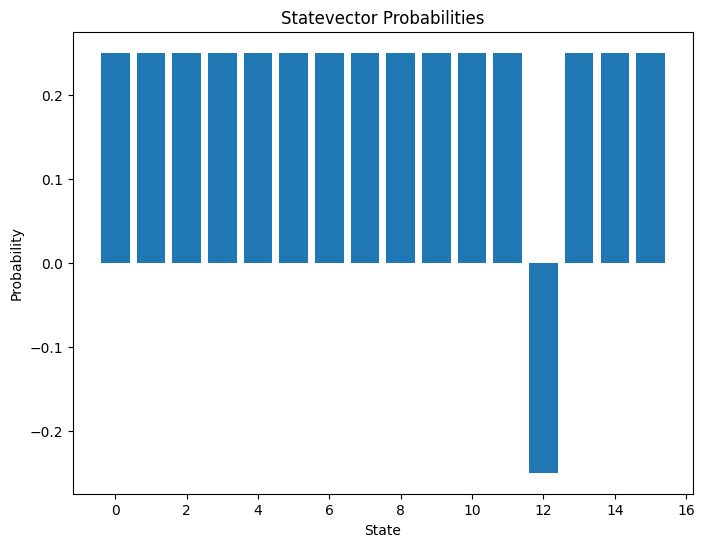

In [19]:
plt.figure(figsize=(8,6))
plt.bar(range(len(statevector.data)), statevector.data)
plt.xlabel('State')
plt.ylabel('Probability')
plt.title('Statevector Probabilities')
plt.show()

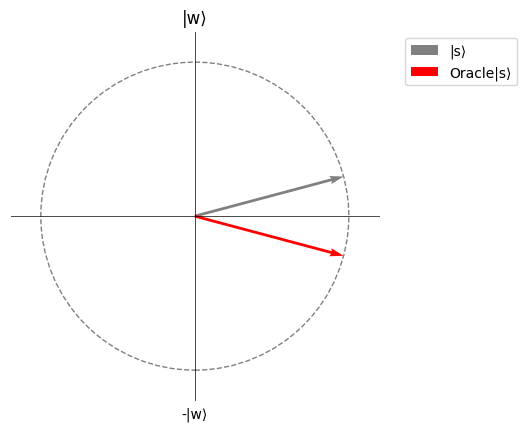

In [20]:
n=4
mag = n**2*100

y = list(w_counts.values())[0] #Use simulation values 
plt.quiver(0, 0, np.sqrt((mag-y)/mag), np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='grey', label= '|s⟩')

plt.quiver(0, 0, np.sqrt((mag-y)/mag), -np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='red', label=r'Oracle|s⟩')

format_plot()

Good! We have flipped the phase! So something IS happening.

But we need a way to map this phase onto the probability so that when we measure the state we get our answer...

### We need to find a way to increase the amplitude of the flipped state |w⟩ and decrease the amplitude of all the other states |s'⟩...

# Step 3: Amplify by reflecting about |s⟩

(aka apply Diffuser , Reflection $U_s$)

To amplify the amplitudes of the correct quantum states we will now **reflect** the state about the uniform superposition state |s⟩ that was input into the Oracle.

This reflection amplifies the amplitude of the solution state while reducing the amplitude of all the other states.

>Remember that the total propability is still 1, so the normalized total amplitudes must be conserved.  Therefore this has the effect of 'diffusing' the amplitude of the wrong states away and it is also referred to as the generalized diffuser.

You can see this pictorally below as the state vector is reflected about the  uniform superposition state |s⟩ , bringing it closer to the solution state |w⟩ and farther from the orthogonal 'wrong states' |s'⟩. (Note the total probability (the length of the full state vector) doesn't change, just it's angle.)

The amplitude vs N states on the right shows how the component of the full state vector that is the solution state |w⟩ (purple) is now amplified relative to all the other states (grey).
While the oracle had flipped the sign of the correct state it had not yet amplified it.



## $ U_s =2|s⟩⟨s|−1 $

Apply an reflection ( $U_s$ ) about the uniform superposition state  $|s⟩ :  

<img src="https://raw.githubusercontent.com/Qiskit/textbook/aebdd2bc86ddb7a79dd8441d52c839d312ffafbb/notebooks/ch-algorithms/images/grover_step3.jpg" width="800"/>

With the application of the diffuser, the register is rotated about |s⟩. The result is that it more closely aligns with |w⟩. All probabilities have been drastically decreased except for that corresponding to the correct answer, which has been increased significantly!


---


## But how is this done?



It is not immediately obvious how to reflect about the uniform superposition state...

We want: $ U_s =2|s⟩⟨s|−1 $ so that everything 'but' the |s⟩ state has a sign flip.

We know that Z gates will flip the sign of the |1⟩ state and that a Control Z gate (CZ) will flip the |11⟩ state to -|11⟩. 

Further we know that a Multi-Controlled-Phase gate (similar to a Toffolli gate) could flip the |11..1⟩ state to -|11..1⟩.

Maybe this can be tranformed to reflect about |s⟩?

What if, starting from the |s⟩ state we apply:

* Hadamard gates: transform |s⟩ → |0000⟩
  * X gates: transform  |0000⟩ → |1111⟩ with bit flips
    * CCZ gate : Multi-Control Phase gate, flipping phase of only |1111⟩ → -|1111⟩
  * X gates: transform  -|1111⟩ → -|0000⟩ with bit flips
*  Hadamard gates: transform  -|0000⟩ → -|s⟩


## Control Phase Gate (CZ gate)

First, let's review the Z gate and the Control Z gate.

The control phase gate flips the sign of the |11⟩ state to -|11⟩ 

For n qubits $|1\rangle ^{\otimes n} \rightarrow -|1\rangle ^{\otimes n}$   ( e.g. $|111\rangle\rightarrow -|111\rangle $ etc. )

We can see this by creating the circuit and getting the unitary matrix of the operation:

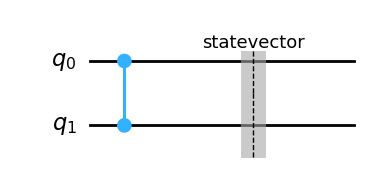

<IPython.core.display.Latex object>

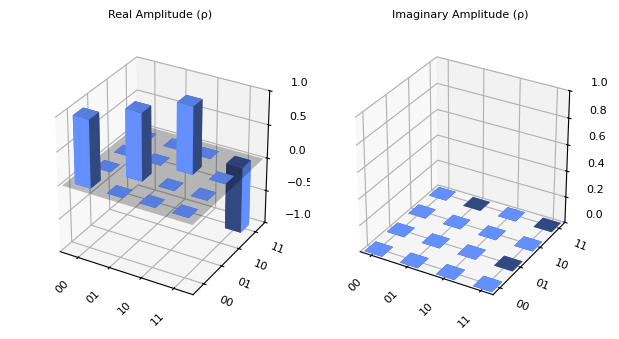

In [21]:
qc = QuantumCircuit(2)
qc.cz(0,1)  # Control Phase gate

matrix = Operator(qc).data

qc.save_statevector()

display(qc.draw('mpl'))

job = QasmSim.run(qc, shots=1)
result = job.result()
statevector = result.get_statevector(qc)
plot_bloch_multivector(statevector)

display(array_to_latex(matrix, prefix="\\text{Circuit = } "))

plot_state_city(matrix,figsize=(6,4))



Nothing happens if the 'control' is 1 and target is zero ....

This is because if the target is 0, then no phase would be applied by the Z gate to the target state.
The Z gate only applies phase to the |1⟩ state of the target qubit.

Therefore the Control Z gate only applies a phase flip if BOTH qubits are 1 (|11⟩).

That is very different from a CNOT!
(CNOT gates still flip the target qubit from 0 to 1, not just 1 to 0.)

> Note a very unusual notation drawing the circuit. **No control or target was drawn by the control phase gate.** This is because the phase is relative to BOTH qubits. Choosing one or the other would be just a global rotation to both.

## Control Phase gate Operator

The Control Phase gate is equivalent to operator 

$CP =  𝟙 - 2 |11\rangle \langle 11|=$

 $\begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1 \end{pmatrix}=\begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{pmatrix} -2\begin{pmatrix} 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{pmatrix}$


____

This isn't quite what we're looking for.

We want: $ U_s =2|s⟩⟨s|−𝟙 $. 

We don't want : $𝟙 - 2|s⟩⟨s|$

However, the difference is just a global phase!

Meaning that the measurement probability will still be the same no matter which version we use!

Nevertheless, in principle we should be able to add Z gates to add a $\pi$ phase to the 1 states flipping the effect of the operator so instead of only changing the sign of a single state, it flips all but the s state - acheving the reflection we want.

Let's confirm that we can invert the sign of the circuit by flipping the sign of the qubits after:

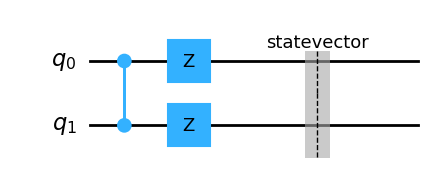

<IPython.core.display.Latex object>

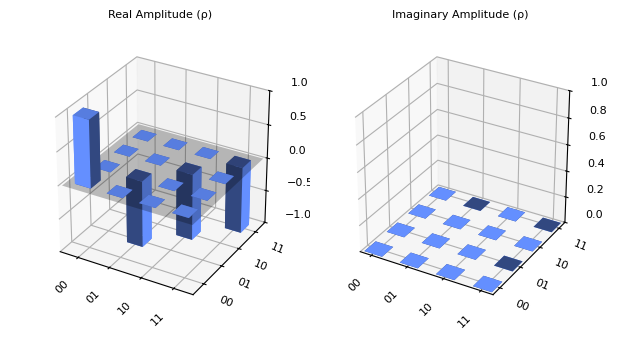

In [22]:
qc = QuantumCircuit(2)

qc.cz(0,1)  # Control Phase gate

qc.z(0)
qc.z(1)

matrix = Operator(qc).data

qc.save_statevector()

display(qc.draw('mpl'))

job = QasmSim.run(qc, shots=1)
result = job.result()
statevector = result.get_statevector(qc)
plot_bloch_multivector(statevector)

display(array_to_latex(matrix, prefix="\\text{Circuit = } "))

plot_state_city(matrix,figsize=(6,4))


This worked!

The additional Z gates flipped the sign of all of the states that are NOT |00⟩ state.

___

We can convince ourselves of the two qubit effect of each Z gate below, each flips the sign of it's qubits 1 state.

This means that the |11⟩ state gets TWO sign flips, going back to positive phase! 

Leaving the CPhase gate to flip the |11⟩ to -|11⟩.

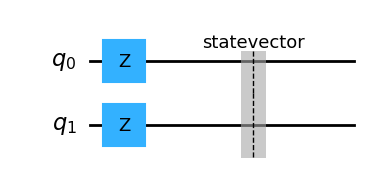

<IPython.core.display.Latex object>

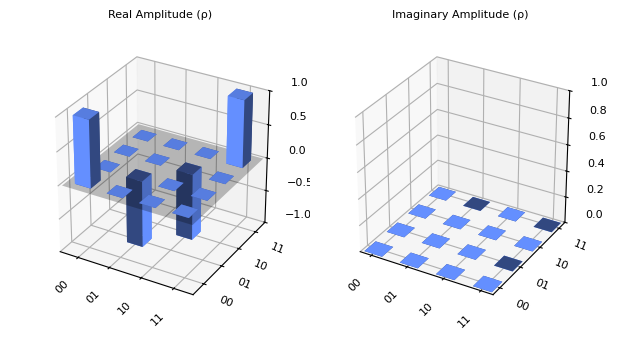

In [23]:
qc = QuantumCircuit(2)

qc.z(0)
qc.z(1)

matrix = Operator(qc).data

qc.save_statevector()

display(qc.draw('mpl'))

job = QasmSim.run(qc, shots=1)
result = job.result()
statevector = result.get_statevector(qc)
plot_bloch_multivector(statevector)

display(array_to_latex(matrix, prefix="\\text{Circuit = } "))

plot_state_city(matrix,figsize=(6,4))


Altogether the CZ gate plus Z gates create:

$ =  2 |00\rangle \langle 00|-𝟙 =$

 $=2\begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \end{pmatrix} -\begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{pmatrix}$

___

We may see now that there is another way to achieve this. We could have simply flipped the bits as well...

Let's try:

<IPython.core.display.Latex object>

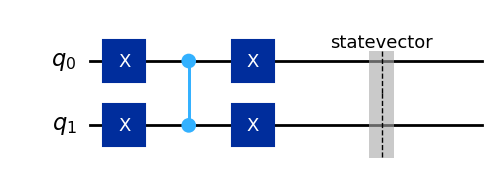

<IPython.core.display.Latex object>

In [24]:
qc = QuantumCircuit(2)

qc.x(0)
qc.x(1)

qc.cz(0,1)  # Control Phase gate

qc.x(0)
qc.x(1)


matrix = Operator(qc).data
display(array_to_latex(matrix, prefix="\\text{Circuit = } "))

qc.save_statevector()

display(qc.draw('mpl'))

job = QasmSim.run(qc, shots=1)
result = job.result()
statevector = result.get_statevector(qc)
statevector.draw('latex')

Flipping the bits with X gates changed the effect of the CPhase gate from:

$ =  𝟙 - 2 |11⟩  \langle 11|$

to 

$ = X^{\otimes n}(𝟙 - 2 |11⟩  \langle 11|) X^{\otimes n} =  𝟙 - 2 |00⟩  \langle 00|$

Which is again the same as:

 $ 2 |00⟩  \langle 00|-𝟙$ 
 
up to a global phase that we won't measure anyway.

Almost there!

___

Lastly, we'll layer Hadamard gates around the operator to tranform from |00⟩ to |++⟩ (aka, the |s⟩ state )

### $ = H^{\otimes n}(𝟙 - 2 |00⟩  \langle 00|) H^{\otimes n} =  𝟙 - 2 |++⟩  \langle ++|=  𝟙 - 2 |s⟩  \langle s|$



<IPython.core.display.Latex object>

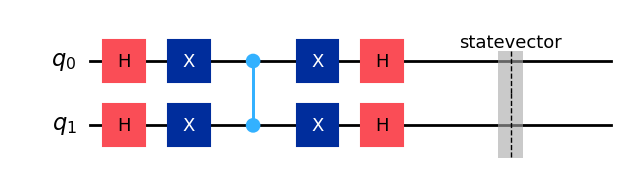

<IPython.core.display.Latex object>

In [25]:
qc = QuantumCircuit(2)

qc.h(0)
qc.h(1)

qc.x(0)
qc.x(1)

qc.cz(0,1)  # Control Phase gate

qc.x(0)
qc.x(1)

qc.h(0)
qc.h(1)


matrix = Operator(qc).data
display(array_to_latex(matrix, prefix="\\text{Circuit = } "))

qc.save_statevector()

display(qc.draw('mpl'))

job = QasmSim.run(qc, shots=1)
result = job.result()
statevector = result.get_statevector(qc)
statevector.draw('latex')

## Review about CZ and CNOT gates


This is simliar to how we converted a Controlled Phase gate (Control Z gate) into a Controlled X Gate (Control Not gate) by first transforming to the phase basis.

* Hadamard on the TARGET qubit (qubit 0) rotates from Z basis to X basis
  * Control Phase gate (rotates the target qubit 0 about Z)
* Hadamard on the TARGET qubit (qubit 0) rotates BACK from X basis to Z basis


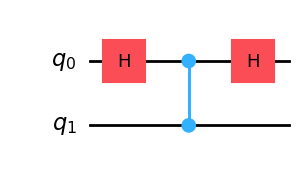

In [26]:
qc = QuantumCircuit(2)

qc.h(0)# Hadamard Gate on TARGET qubit
qc.cz(0,1)# Control Phase gate
qc.h(0)# Hadamard Gate on TARET qubit

qc.draw('mpl')

In [27]:
qc = QuantumCircuit(2)
qc.h(0)# Hadamard Gate on TARGET qubit
qc.cz(0,1)# Control Phase gate
qc.h(0)# Hadamard Gate on TARET qubit

qc.save_unitary()

job = QasmSim.run(qc, shots=1)
result = job.result()

# Display the results:
array_to_latex(result.get_unitary(qc,3), prefix="\\text{Circuit = } ")

<IPython.core.display.Latex object>

And as review we can check that this is equivalent to a CNOT gate:

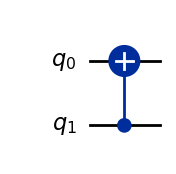

<IPython.core.display.Latex object>

In [28]:
qc = QuantumCircuit(2)

qc.cx(1,0)# Control Phase gate

display(qc.draw('mpl'))

qc.save_unitary()

job = QasmSim.run(qc, shots=1)
result = job.result()

# Display the results:
array_to_latex(result.get_unitary(qc,3), prefix="\\text{Circuit = } ")

IBM Qisket notation has the register 'backwards'... (least significant bit is to the right)...
Anyway, that is why the CNOT above looks 'backwards' relative to the matrix...

## Steps to create the amplitude amplification circuit:

SO now we know we can flip the |1111⟩ state with a CZ gate, so if we want to flip our state we have to transform it into the |1111⟩ state with rotations:

1. Convert |++++⟩ → |0000⟩ by applying Hadamard gates to all qubits
   
   Remember |s⟩ is the uniform superposition state we started with after applying Hadamards to each qubit. So to get back from |s⟩ to |0⟩ again we just apply Hadmard gates once more.

   HOWEVER, if a state had it's sign flipped by the Oracle it does not return to |0⟩.  Instead it is |1⟩! This is critical for the algorithm to work.

1. Apply a negative phase to anything except the |0000⟩  state
  1. Flip all qubits from 0 to 1 by applying X gates (conversely 1 to 0)
  1. Apply multi-qubit controlled phase gate ( like a 'phase' Toffoli)
  
      >Flipping the sign of the |1111⟩ state (which was just originally in the |0000⟩ state)

  1. Flip all qubits back from |1111⟩ to |0000⟩ by applying X gates
1. Convert back from |0000⟩ to superposition state |++++⟩ 'basis' by applying Hadamard gates to all qubits.

Let's see how to create this diffuser operation:

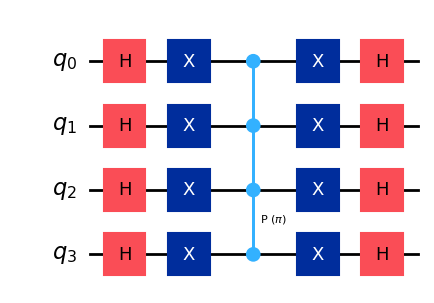

In [29]:
def create_diffuser(n_qubits):
    """Creates a diffuser circuit for Grover's algorithm
    
    Args:
        n_qubits (int): Number of qubits in the circuit
        
    Returns:
        QuantumCircuit: The diffuser circuit
    """
    qc = QuantumCircuit(n_qubits)

    '''1. Rotate from |s> to |000...0> (H-gates on all qubits)'''
    for qubit in range(n_qubits):
        qc.h(qubit)

    '''2. Rotate from |000...0> to |111...1> (X-gates on all qubits)'''
    for qubit in range(n_qubits):
        qc.x(qubit)

    '''3. Flip the sign of the |111...1> state (Multi-controlled-Z gate on all qubits)'''
    qc.append(MCPhaseGate(lam=pi , num_ctrl_qubits=n_qubits-1), list(range(n_qubits)))

    '''REVERSE REVERSE'''

    '''4. Rotate from |111...1> to |000...0> (X-gates on all qubits)'''
    for qubit in range(n_qubits):
        qc.x(qubit)

    '''5. Rotate from |000...0> to |s>  (H-gates on all qubits)'''
    for qubit in range(n_qubits):
        qc.h(qubit)

    qc.name = "U$_s$ - Reflect about |s⟩"
        
    return qc

# Create 4-qubit diffuser circuit
qc = create_diffuser(4)

U_s = qc.to_gate()
U_s.name = "U$_s$ - Reflect about |s⟩"

qc.draw('mpl')

## $U_s$ - aka the 'Diffuser', aka reflection about |s⟩
Compile the diffuser circuit into a single for convienence
(We call it $U_s$ to refer to it's reflection about the original |s> state)

<IPython.core.display.Latex object>

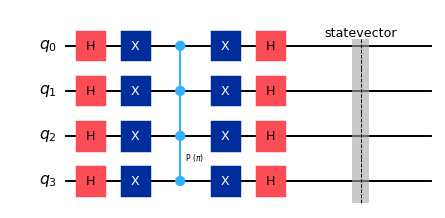

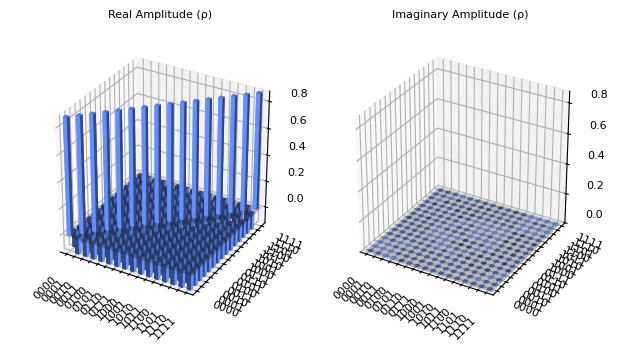

In [30]:
# Create n-qubit diffuser circuit
n = 4
qc = create_diffuser(n)
U_s = qc.to_gate()

matrix = Operator(U_s).data
display(array_to_latex(matrix, prefix="\\text{Circuit = } "))

qc.save_statevector()

display(qc.draw('mpl',scale = 0.7))

job = QasmSim.run(qc, shots=1)
result = job.result()
statevector = result.get_statevector(qc)
statevector.draw('latex')

statevector.draw('city' , figsize = (8,5))

plot_state_city(matrix,figsize=(6,4))


## Decomposing a multi-qubit Controlled phase gate

5


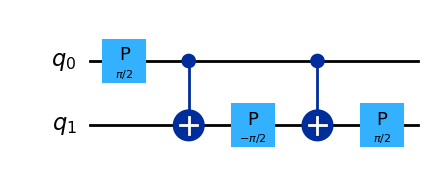

In [31]:
n=2
qc_MCPHASEGATE = QuantumCircuit(n)

'''Multi-controlled-Z gate'''
qc_MCPHASEGATE.append(MCPhaseGate(lam=pi , num_ctrl_qubits=n-1),list(range(0,n)))

decomposed_circ = qc_MCPHASEGATE.decompose().decompose()

'''Calculate the depth of the quantum circuit'''
print(decomposed_circ.depth())

decomposed_circ.draw('mpl',fold = 50)


12


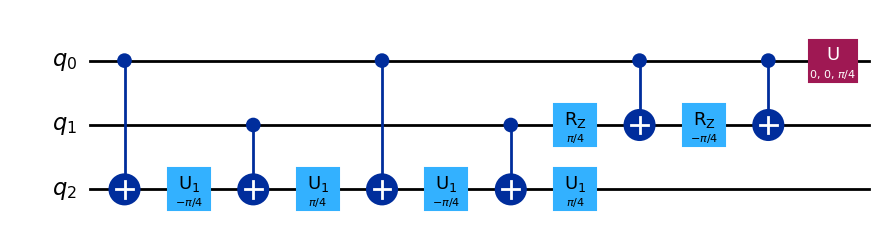

In [32]:
n=3
qc_MCPHASEGATE = QuantumCircuit(n)

'''Multi-controlled-Z gate'''
qc_MCPHASEGATE.append(MCPhaseGate(lam=pi , num_ctrl_qubits=n-1),list(range(0,n)))

decomposed_circ = qc_MCPHASEGATE.decompose().decompose()

'''Calculate the depth of the quantum circuit'''
print(decomposed_circ.depth())

decomposed_circ.draw('mpl',fold = 50)


28


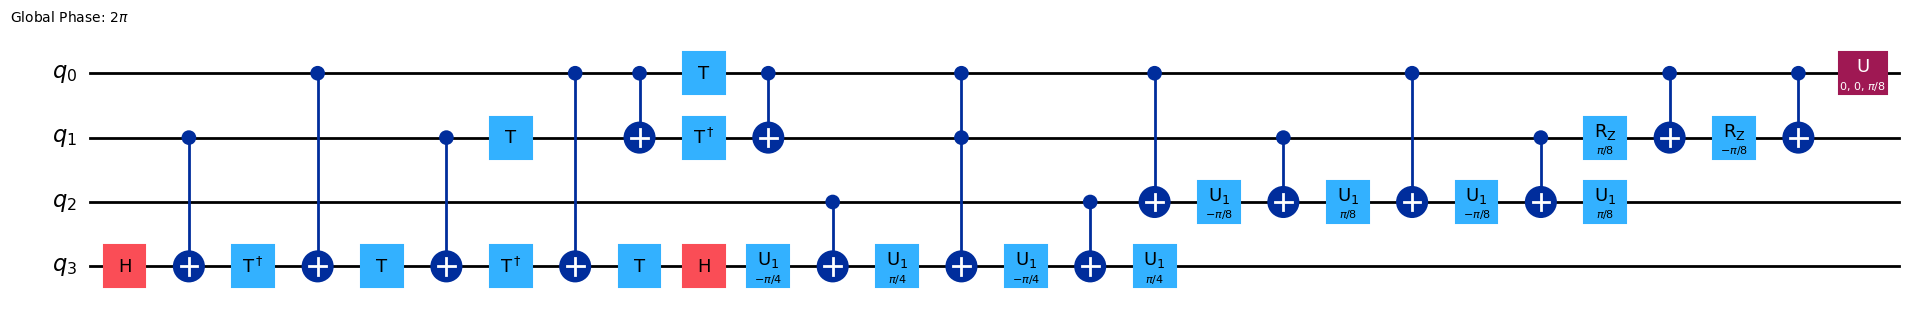

In [33]:
n=4
qc_MCPHASEGATE = QuantumCircuit(n)

'''Multi-controlled-Z gate'''
qc_MCPHASEGATE.append(MCPhaseGate(lam=pi , num_ctrl_qubits=n-1),list(range(0,n)))

decomposed_circ = qc_MCPHASEGATE.decompose().decompose()

'''Calculate the depth of the quantum circuit'''
print(decomposed_circ.depth())

decomposed_circ.draw('mpl',fold = 50)


We see that much like the 'Controlled-Control-X Gate' (CCX, Toffoli Gate), executing the Controlled-Control-Phase gate on actual qubits requires many two qubit operations.

Two qubit Control Phase gates & Two qubit CNOT gates

13 total gates for just a 4 qubit register

> Note the massively entangled state created from these operations!

# Putting the Reflection together with the Oracle

Apply reflection gate to the rest of our circuit to amplify the solution.

First the statevector (before measuring)

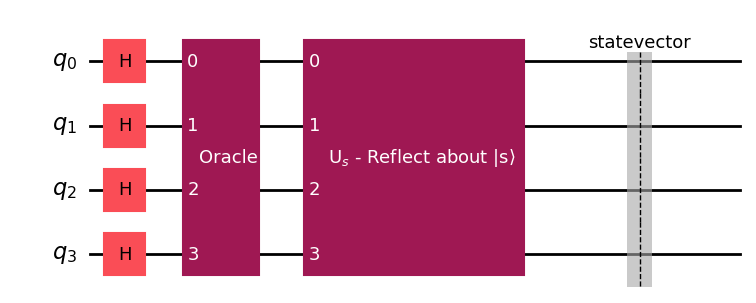

In [34]:
n = 4 # Number of qubits

quantum_circuit = QuantumCircuit(n)

for i in range(n):
    quantum_circuit.h(i)

# Add the Oracle gate
quantum_circuit.append(Oracle, range(n))

# Add the Diffuser (U_s)
U_s  = create_diffuser(n).to_gate()
quantum_circuit.append(U_s, range(n))

quantum_circuit.save_statevector() #Measure Statevector

'''OMIT MEASUREMENTS TO PRESERVE STATEVECTOR'''

quantum_circuit.draw('mpl')

<IPython.core.display.Latex object>

c:\Users\rniffenegger\Anaconda3\envs\quantum\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\rniffenegger\Anaconda3\envs\quantum\Lib\site-packages\matplotlib\transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


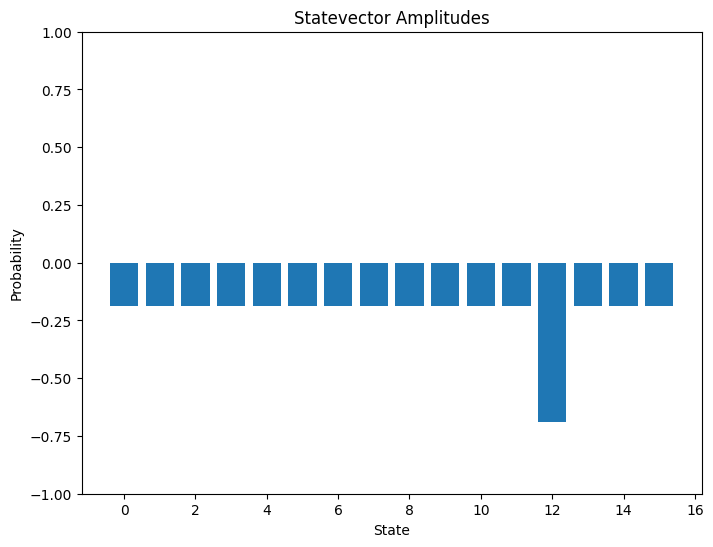

In [35]:
#Simulate
job_sim = QasmSim.run(quantum_circuit.decompose(), shots=n_shots)
result_sim = job_sim.result()

# Get the statevector from result
statevector = result_sim.get_statevector(quantum_circuit)

# print(statevector)
display(statevector.draw('latex'))

# plot_state_city(statevector)
# statevector.draw('city' , figsize = (8,5))

plt.figure(figsize=(8,6))
plt.bar(range(len(statevector.data)), statevector.data)
plt.xlabel('State')
plt.ylabel('Probability')
plt.title('Statevector Amplitudes')
plt.ylim(-1, 1) 
plt.show()

We can see that the amplitude of the answer is increasing (albeit negative)!


Adding measurements to get the probabilities:

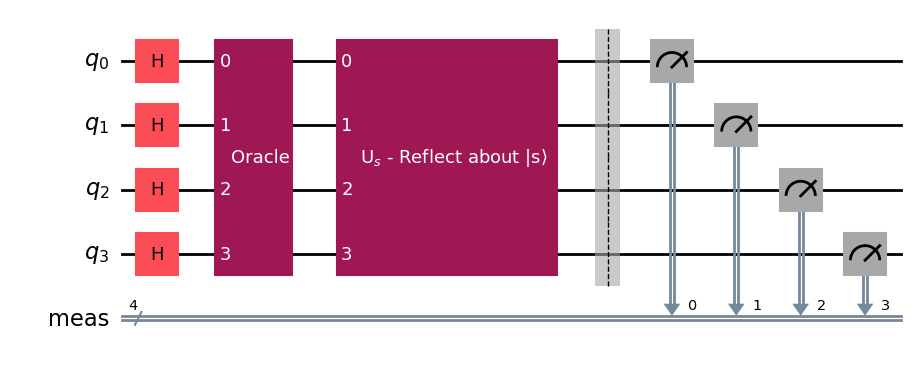

In [36]:
n = 4 # Number of qubits

quantum_circuit = QuantumCircuit(n)

for i in range(n):
    quantum_circuit.h(i)

# Add the Oracle gate
quantum_circuit.append(Oracle, range(n))

# Add the Diffuser (U_s)
U_s  = create_diffuser(n).to_gate()
quantum_circuit.append(U_s, range(n))

# Measurements
quantum_circuit.measure_all()

#Draw circuit
quantum_circuit.draw('mpl')


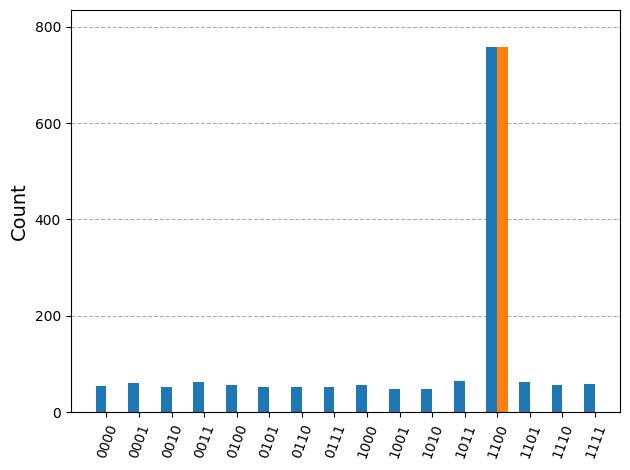

In [37]:
'''Simulate algorithm so far'''

QasmSim = QasmSimulator() #Set simulator to evolve state

n_shots = (2**n)*100 #Use 100 trials per bit string

job_sim = QasmSim.run(quantum_circuit.decompose(), shots=n_shots)

result_sim = job_sim.result()
counts = result_sim.get_counts(quantum_circuit)

# Get counts for state |1100⟩ (12 in decimal)
w_counts_Grover1 = {'1100': counts.get('1100', 0)}

plot_histogram([counts,w_counts_Grover1], bar_labels=False)

Wow! One iteration and already we really see a huge effect! We already have a nearly 50% chance of getting the correct solution each shot. Not bad.


However, we can actually iterate one more time to fully rotate closer to 100%!

0.6887488656977956
0.725


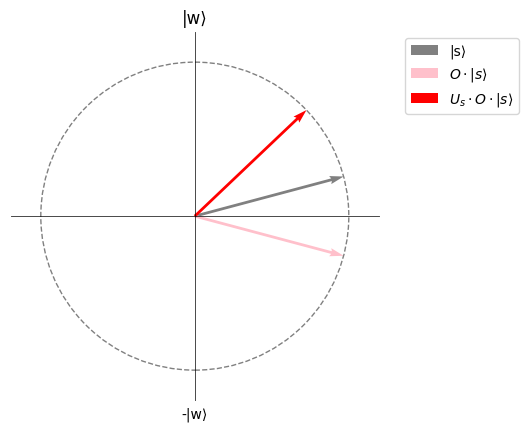

In [40]:
n=4
mag = n**2*100


y = list(w_counts.values())[0]

plt.quiver(0, 0, np.sqrt((mag-y)/mag), np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='grey', label= '|s⟩')

plt.quiver(0, 0, np.sqrt((mag-y)/mag), -np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='pink', label=r'$O \cdot |s⟩$')

y = list(w_counts_Grover1.values())[0]
plt.quiver(0, 0, np.sqrt((mag-y)/mag), np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='red', label=r'$U_s \cdot O \cdot |s⟩$')

print(np.sqrt(y/mag))
print(np.sqrt((mag-y)/mag))

format_plot()


The angle is now $\theta = 3\cdot\arcsin(1/\sqrt{N}) = 3\cdot\arcsin(1/4)\approx 45 \deg$


# Iterate by repeatedly applying the Grover operator

Combining the Oracle and the Diffuser (reflection about |s⟩) we can create the **Grover Operator**.

Typically, we must execute the Grover Operator $(\mathcal{O}\sqrt{N})$ times, which means larger searches do indeed take more time, even on a quantum computer. Regardless a quadratic speedup is still observed!

For n_qubits = 4 

$N = 2^n = 16$

$\sqrt{N} = 2^{n/2} = 4$

Let's try iterating just twice and see what happens.

16


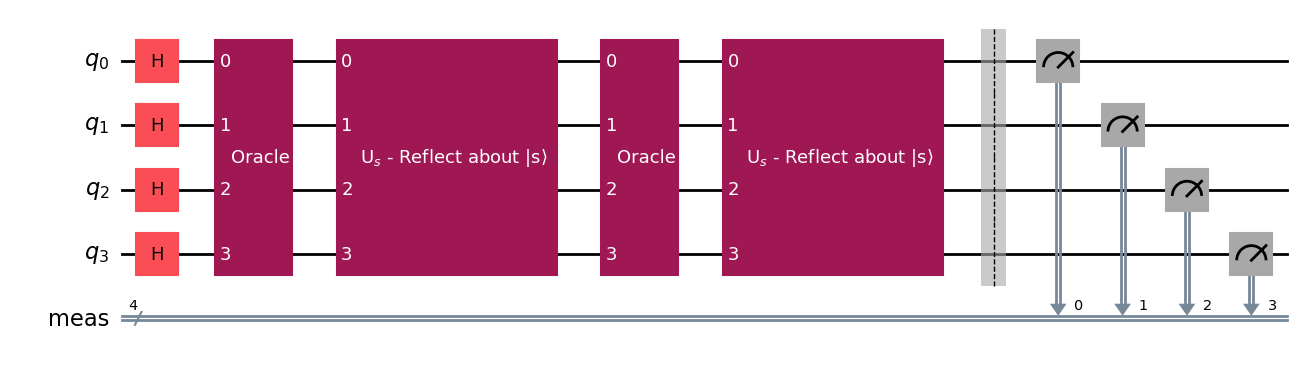

In [41]:
n = 4 # Number of qubits

N = 2**n

iterations = sqrt(N)
iterations = 2

print(N)

quantum_circuit = QuantumCircuit(n)

# Add Hadamard gates to each qubit
for i in range(n):
    quantum_circuit.h(i)

# Apply Oracle and Diffuser (Grover operator) sqrt(N) times
for i in range(int(iterations)):
    quantum_circuit.append(Oracle, range(n))
    U_s  = create_diffuser(n).to_gate()
    quantum_circuit.append(U_s, range(n))

# Conclude by making measurements
quantum_circuit.measure_all()

quantum_circuit.draw('mpl', fold = 100)

# Execute the circuit!

Now we can execute the circuit and meaure many trials or 'shots' and hopefully see that the correct answer is measured far more often than any other. This step finally collapses the wavefunction of our registers and effectively converts it to a classical register with a value corresponding to the correct search index.

Simulation runtime: 0.008


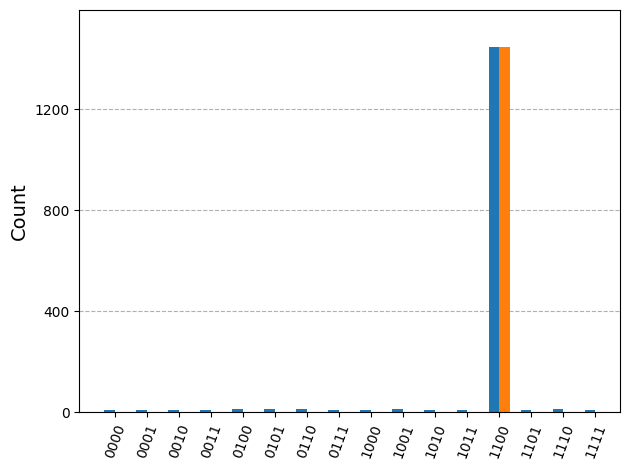

In [42]:
# Record the time it takes to simulate
start = time.time()

'''Simulate algorithm'''
n=4
n_shots = n**2*100
job_sim = QasmSim.run(quantum_circuit.decompose(), shots=n_shots)
result_sim = job_sim.result()
counts = result_sim.get_counts(quantum_circuit)

# How long did this take?
elapsed = round(time.time() - start,3)
print("Simulation runtime: " + str(elapsed))

# Get counts for state |1100⟩ (12 in decimal)
w_counts_Grover2 = {'1100': counts.get('1100', 0)}


plot_histogram([counts,w_counts_Grover2], bar_labels=False)


Wow, we see that two iterations have really isolated the result and more iterations are not necessary.

In fact, they would make the result worse in all cases as the vector would overrotate and noise would diminish the amplitude.

In [43]:
#Get the most likely measured result from the counts
answer = counts.most_frequent()
print( 'Most frequent measured bit string = ' , answer)
print( 'Most frequent measured integer = ' ,int(answer,2))

#What was the desired solution again?
print( '\nDesired solution = ' , solution)

print('\nTotal counts of most frequent result = ' , counts[answer] )
print('Total shots = ' , n_shots)
print('Probability of getting answer = ' , round(counts[answer]/n_shots *100,2) ,'%')


Most frequent measured bit string =  1100
Most frequent measured integer =  12

Desired solution =  12

Total counts of most frequent result =  1449
Total shots =  1600
Probability of getting answer =  90.56 %


92% ✅ Not bad!

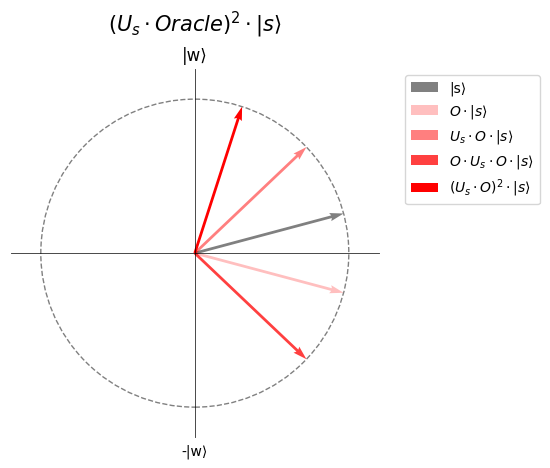

In [44]:

n=4
mag = n**2*100

y = list(w_counts.values())[0]  
plt.quiver(0, 0, np.sqrt((mag-y)/mag), np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='grey', label= '|s⟩')

plt.quiver(0, 0, np.sqrt((mag-y)/mag), -np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='red', label=r'$O \cdot |s⟩$', alpha = 0.25)

y = list(w_counts_Grover1.values())[0]
plt.quiver(0, 0, np.sqrt((mag-y)/mag), np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='red', label=r'$U_s \cdot O \cdot |s⟩$' , alpha = 0.5)

y = list(w_counts_Grover1.values())[0]
plt.quiver(0, 0, np.sqrt((mag-y)/mag), -np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='red', label=r'$ O \cdot U_s \cdot O \cdot |s⟩$', alpha = 0.75)

y = list(w_counts_Grover2.values())[0]
plt.quiver(0, 0, np.sqrt((mag-y)/mag), np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='red', label=r'$(U_s \cdot O)^2 \cdot |s⟩$')

plt.text(0.5, 1.1, r'$ (U_s\cdot Oracle)^2\cdot|s⟩$', horizontalalignment='center', transform=plt.gca().transAxes,fontsize=15)

format_plot()


The angle is now $\theta = 5\cdot\arcsin(1/\sqrt{N}) = 5\cdot\arcsin(1/4)\approx 75 \deg$


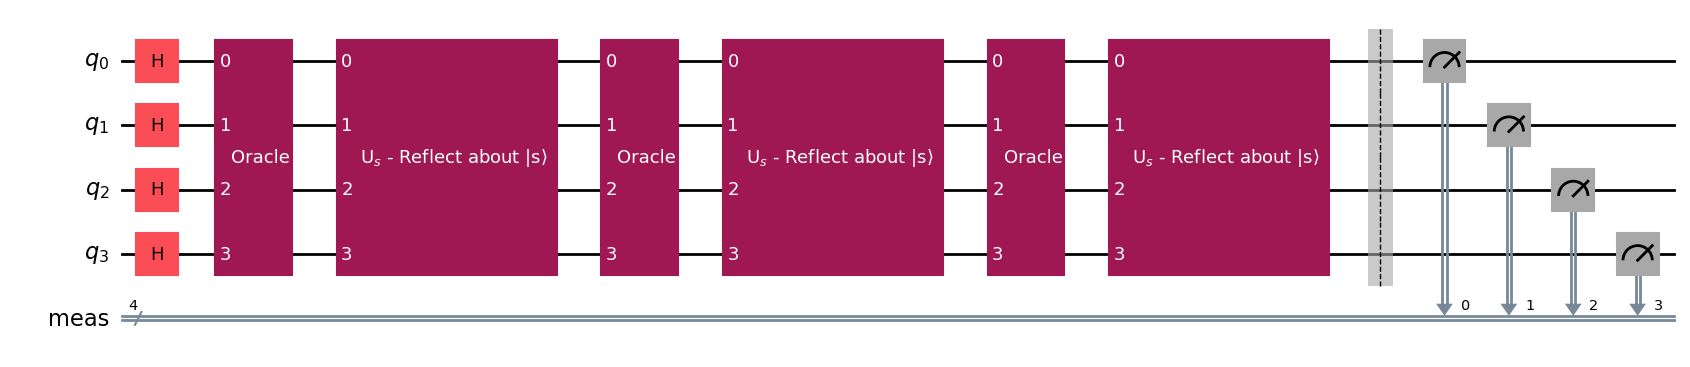

In [45]:
n = 4 # Number of qubits
N = 2**n

iterations = sqrt(N)
iterations = 3

quantum_circuit = QuantumCircuit(n)

for i in range(n):
    quantum_circuit.h(i)

# Apply Oracle and Diffuser (Grover operator) sqrt(N) times
for i in range(int(iterations)):
    quantum_circuit.append(Oracle, range(n))
    U_s  = create_diffuser(n).to_gate()
    quantum_circuit.append(U_s, range(n))

quantum_circuit.measure_all()
quantum_circuit.draw('mpl', fold = 100)

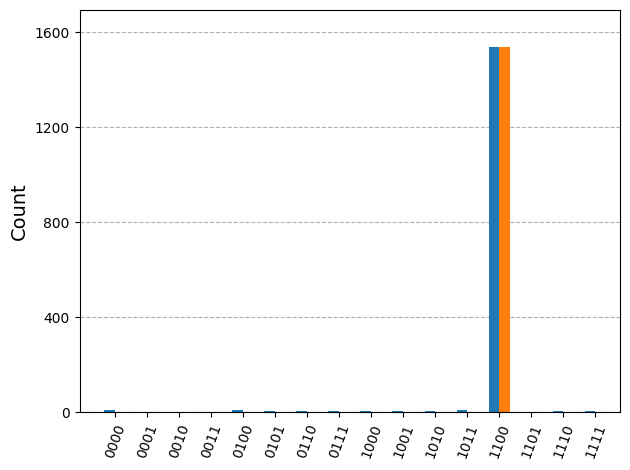

In [46]:
job_sim = QasmSim.run(quantum_circuit.decompose(), shots=n_shots)
result_sim = job_sim.result()
counts = result_sim.get_counts(quantum_circuit)


w_counts_Grover3 = {'1100': counts.get('1100', 0)}
plot_histogram([counts,w_counts_Grover3], bar_labels=False)

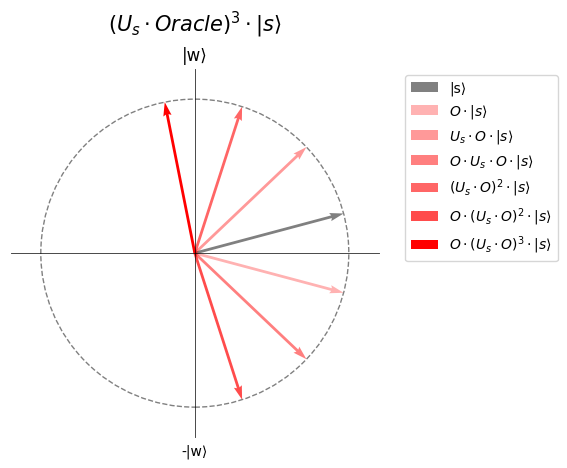

In [47]:
n=4
mag = n**2*100

y = list(w_counts.values())[0]  
plt.quiver(0, 0, np.sqrt((mag-y)/mag), np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='grey', label= '|s⟩')

plt.quiver(0, 0, np.sqrt((mag-y)/mag), -np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='red', label=r'$O \cdot |s⟩$', alpha = 0.3)

y = list(w_counts_Grover1.values())[0]
plt.quiver(0, 0, np.sqrt((mag-y)/mag), np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='red', label=r'$U_s \cdot O \cdot |s⟩$' , alpha = 0.4)

y = list(w_counts_Grover1.values())[0]
plt.quiver(0, 0, np.sqrt((mag-y)/mag), -np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='red', label=r'$ O \cdot U_s \cdot O \cdot |s⟩$', alpha = 0.5)

y = list(w_counts_Grover2.values())[0]
plt.quiver(0, 0, np.sqrt((mag-y)/mag), np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='red', label=r'$(U_s \cdot O)^2 \cdot |s⟩$', alpha = 0.6)

y = list(w_counts_Grover2.values())[0]
plt.quiver(0, 0, np.sqrt((mag-y)/mag), -np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='red', label=r'$ O\cdot (U_s \cdot O)^2 \cdot |s⟩$', alpha = 0.7)

y = list(w_counts_Grover3.values())[0]
plt.quiver(0, 0, -np.sqrt((mag-y)/mag), np.sqrt(y/mag), angles='xy', scale_units='xy', scale=1, color='red', label=r'$ O\cdot (U_s \cdot O)^3 \cdot |s⟩$')


plt.text(0.5, 1.1, r'$ (U_s\cdot Oracle)^3 \cdot|s⟩$', horizontalalignment='center', transform=plt.gca().transAxes,fontsize=15)

format_plot()



## Overrotated!!

Now we see that we've actually over rotated past the optimal answer and the further interations would just continue to rotated us farther from the answer.

The angle is now $\theta = 7\cdot\arcsin(1/\sqrt{N}) = 7\cdot\arcsin(1/4)\approx 105 \deg$


Only 3 iteractions were needed!

Turns out it can be shown that the optimal number of iterations is:  $\frac{\pi}{4}\sqrt{N}$

This is because we always want a final angle of $\frac{\pi}{4}$ (90°) and the initial angle of the superposition state will always be : $\arcsin(1/\sqrt{N})$ 

Thus dividing them gives the optimal number of iterations.

> See Thomas Wong's Textbook

Which for n=4 and N=16 means the optimal number of iterations is : $\frac{\pi}{4}\sqrt{16}=\pi \approx 3$

# Real QPU

In [48]:
def backend_real(qc, backend=None, shots=1000, optimization_level=3):
    """
    Run a quantum circuit on a real QPU backend
    
    Args:
        qc (QuantumCircuit): Circuit to run
        backend (Backend): Backend to run on, defaults to most idle QPU
        shots (int): Number of shots to run, defaults to 1000
        
    Returns:
        dict: Counts from running the circuit
    """

    if backend is None:
        service = QiskitRuntimeService()
        backend = service.least_busy(operational=True, simulator=False)
        print(backend)

    pm = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend, seed_transpiler=0)
    tqc = pm.run(qc)

    sampler = Sampler(backend)
    job = sampler.run([tqc],shots=shots)

    result = job.result()

    data_keys = list(result[0].data.keys())
    counts = result[0].data[data_keys[0]].get_counts()

    return counts

In [121]:
counts = backend_real(quantum_circuit)

<IBMBackend('ibm_kyiv')>


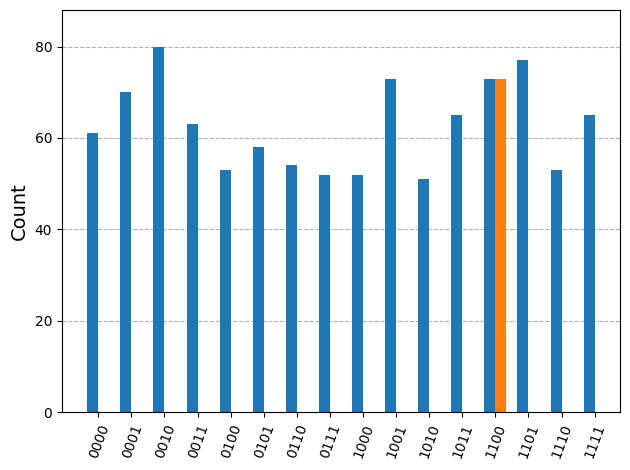

In [161]:
filtered_counts = {k:v for k,v in counts.items() if k=='1100'}
plot_histogram([counts,filtered_counts], bar_labels=False)


In [162]:
#Get the most likely measured result from the counts
answer = max(counts, key=counts.get)
print( 'Most frequent measured bit string = ' , answer)
print( 'Most frequent measured integer = ' ,int(answer,2))

#What was the desired solution again?
print( '\nDesired solution = ' , solution)

print('\nTotal counts of most frequent result = ' , counts[answer] )
print('Total shots = ' , n_shots)
print('Probability of getting answer = ' , round(counts[answer]/n_shots *100,2) ,'%')


Most frequent measured bit string =  0010
Most frequent measured integer =  2

Desired solution =  12

Total counts of most frequent result =  80
Total shots =  1024
Probability of getting answer =  7.81 %


In [126]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

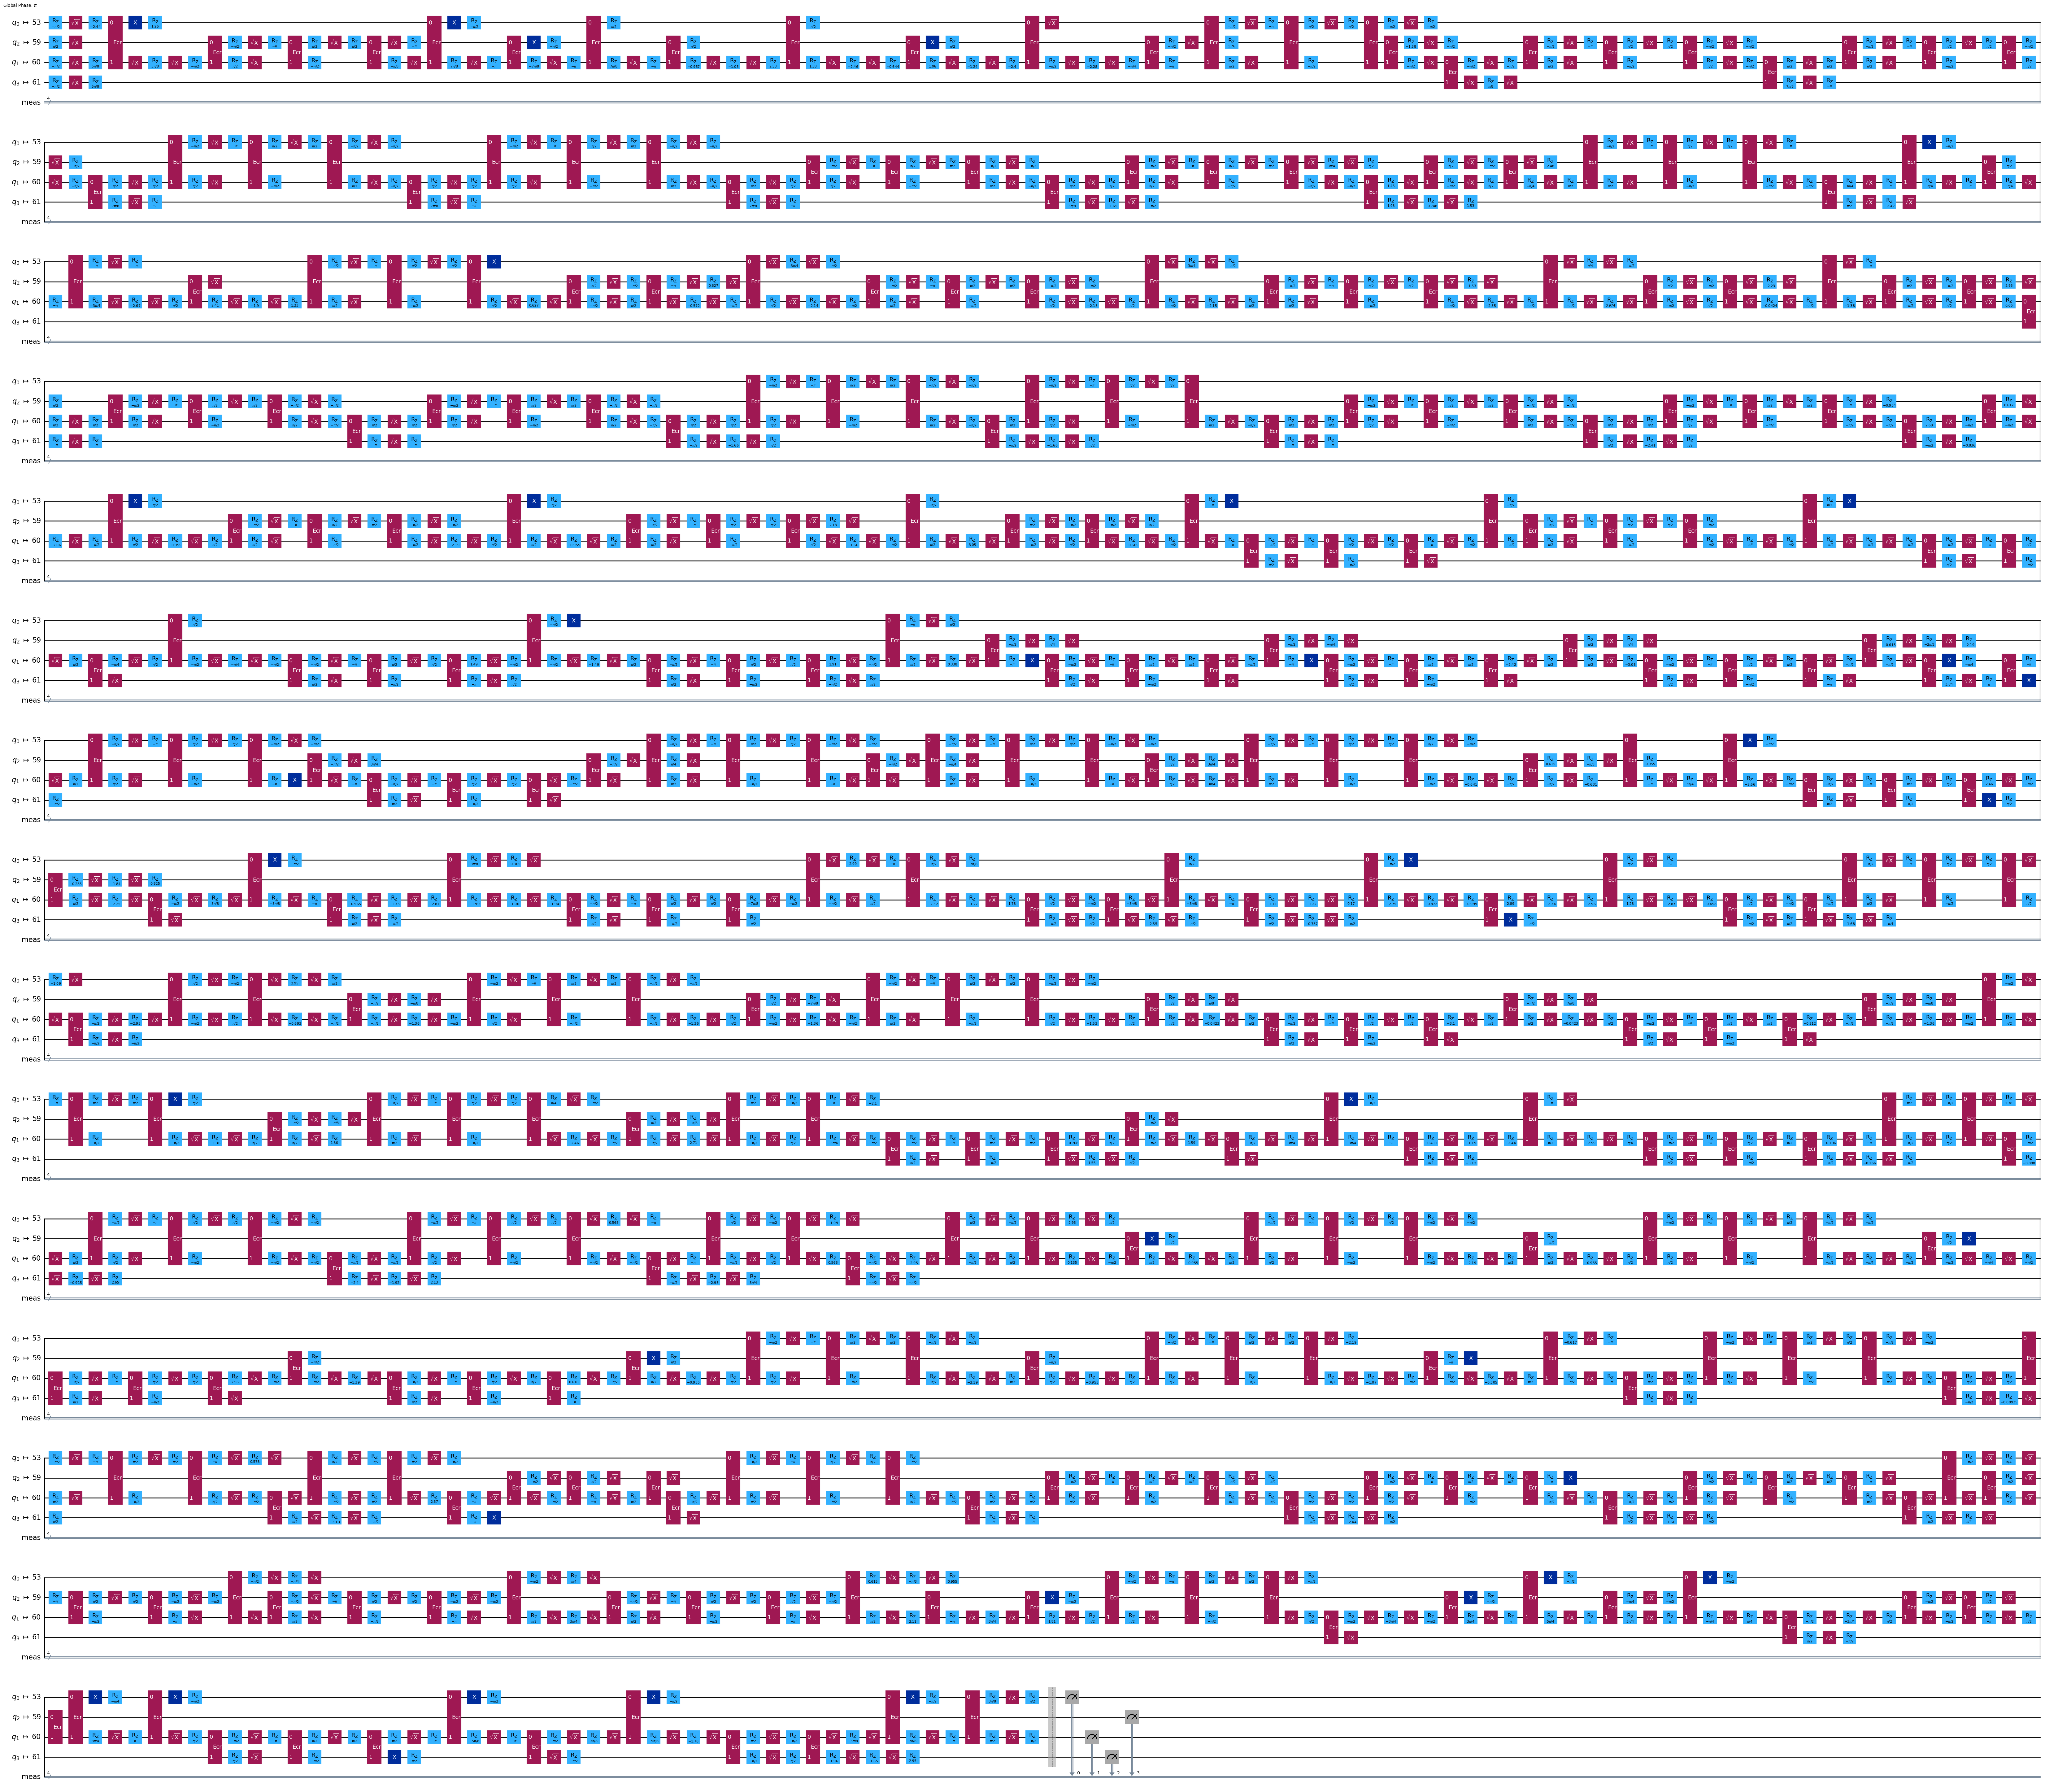

In [133]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
tqc = pm.run(quantum_circuit)
tqc.draw('mpl',fold=100)

In [135]:
# Count the number of gates in the transpiled circuit
gate_counts = tqc.count_ops()
print("Gate counts in transpiled circuit:")
for gate, count in gate_counts.items():
    print(f"{gate}: {count}")


Gate counts in transpiled circuit:
rz: 1156
sx: 699
ecr: 344
x: 39
measure: 4
barrier: 1


This looks like it will be quie difficult to run on a QPU without extremely low errors -or- native controlled phase gates...

# How well does this scale ***classically***?

To see how well this scales on the classical simulator, let's run the above code for several values of N and time how long it takes.

In [163]:
min_bits = 3
max_bits = 8
elapsed_times = []

desired_solution = 3

for n in range(min_bits, max_bits+1):

    ## Create register
    quantum_circuit = QuantumCircuit(n)

    ## Create superposition
    for i in range(n):
        quantum_circuit.h(i)

    #Create Oracle Gate
    controls = QuantumRegister(n)
    circuit = QuantumCircuit(controls)
    matrix = np.identity(2**n, complex)
    matrix[desired_solution, desired_solution]*=-1
    gate = Operator(matrix)
    circuit.unitary(gate, range(0, n))
    Oracle_N = circuit.to_gate()
    Oracle_N.name = 'Oracle_N'


    '''
    Create Diffuser Gate
    '''
    qc = QuantumCircuit(n)
    for qubit in range(n):
        qc.h(qubit)
    for qubit in range(n):
        qc.x(qubit)

    '''
    Multi-controlled-Z gate
    ------------------
    Sandwiching Hadmard gates around the target qubit
    --> Converts a CCX gate to a CCZ gate
    (This is easier to script for variable qubit numbers)
    '''
    #Hadamard to convert CNOT gate to Cphase gate
    qc.h(n-1)

    #CCNOT gate (Toffili)
    qc.mcx(list(range(n-1)), n-1)

    #Hadamard to convert back after application of CCX
    qc.h(n-1)

    for qubit in range(n):
        qc.x(qubit)
    for qubit in range(n):
        qc.h(qubit)

    #Compile into single 'gate'
    U_s = qc.to_gate()
    U_s.name = "U$_s$"

    # Apply sqrt(n) Oracle and Diffuser Gates to register
    for i in range(int(np.sqrt(n))):
        quantum_circuit.append(Oracle_N, range(n))
        quantum_circuit.append(U_s, range(n))

    #Add Measurements
    quantum_circuit.measure_all()

    #Measure simulation time
    start = time.time()

    '''Simulate algorithm'''
    n_shots = 1024
    decomposed_circ = quantum_circuit.decompose() # Does not modify original circuit
    decomposed_circ2 = decomposed_circ.decompose() # Does not modify original circuit
    decomposed_circ3 = decomposed_circ2.decompose().decompose() # Does not modify original circuit
    job_sim = QasmSim.run(decomposed_circ3, shots=n_shots)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(quantum_circuit)

    sim_time = round(time.time() - start,3)
    elapsed_times.append(sim_time)
    print("SOLVED: n = " + str(n) + " qubits in " , sim_time, 'seconds')



SOLVED: n = 3 qubits in  0.019 seconds
SOLVED: n = 4 qubits in  0.175 seconds
SOLVED: n = 5 qubits in  0.473 seconds
SOLVED: n = 6 qubits in  1.534 seconds
SOLVED: n = 7 qubits in  6.809 seconds
SOLVED: n = 8 qubits in  29.326 seconds


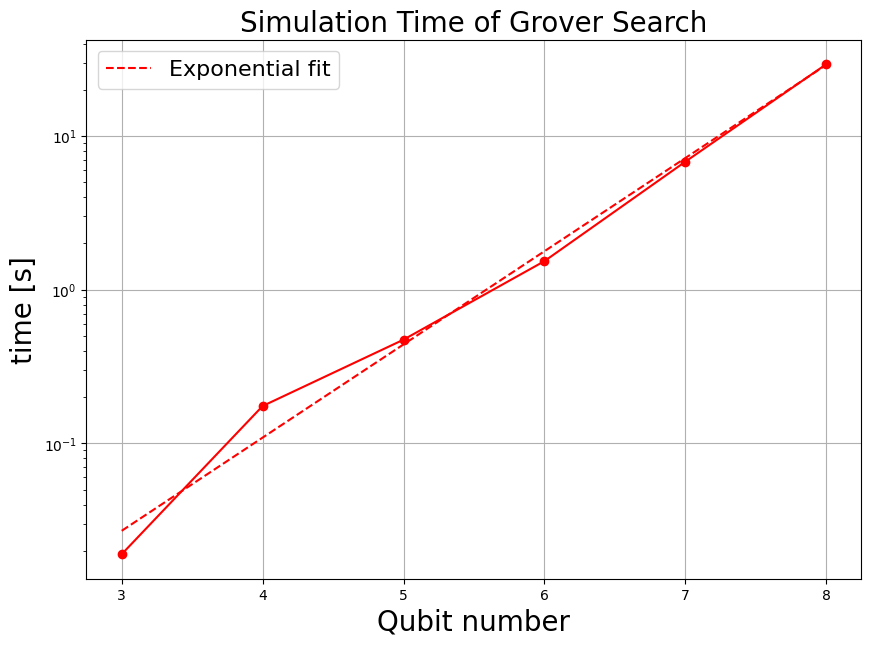

In [169]:
'''
Plot simulation time vs. Qubit number
'''
figsize = 10
plt.figure(figsize=(figsize,figsize*0.7))
ax = plt.gca()

plt.plot(range(min_bits, max_bits+1), elapsed_times , 'o-r')

fs=20 #fontsize
plt.title('Simulation Time of Grover Search', fontsize=fs)
ax.set_ylabel(r'time [s]', fontsize=fs);
ax.set_xlabel(r'Qubit number', fontsize=fs);
plt.grid()
plt.yscale('log')  # Set y-axis to logarithmic scale

# Add exponential fit
def fit_exponential(x_data, y_data):
    # Fit exponential curve: y = a*exp(b*x) 
    a, b = np.polyfit(x_data, np.log(y_data), 1)
    return a, b

def generate_fit_curve(a, b, x_min, x_max, num_points=100):
    x_fit = np.linspace(x_min, x_max, num_points)
    y_fit = np.exp(a*x_fit + b)
    return x_fit, y_fit

# Fit data and generate smooth curve
x_data = np.array(range(min_bits, max_bits+1))
y_data = np.array(elapsed_times)
a, b = fit_exponential(x_data, y_data)
x_fit, y_fit = generate_fit_curve(a, b, min(x_data), max(x_data))

# Plot fit curve
plt.plot(x_fit, y_fit, '--r', label=f'Exponential fit')
plt.legend(fontsize=fs-4)


## Exponential Scaling Classically
The time to simulate Grover's Search increases **exponentially** on a classical computer.

This is due to the fact that the operator matrices **double** in size every time we increase the number of qubits in the simulation.

As a result we cannot rely on classical computers to perform this algorithm!

Quantum solutions to Grover's search show a quadratic speedup compared to classical solutions and actual quantum computers would be needed to show a speedup (on very large problems)...

---

Plotting the results of the last simulation (but only plotting a subset of all possible strings):

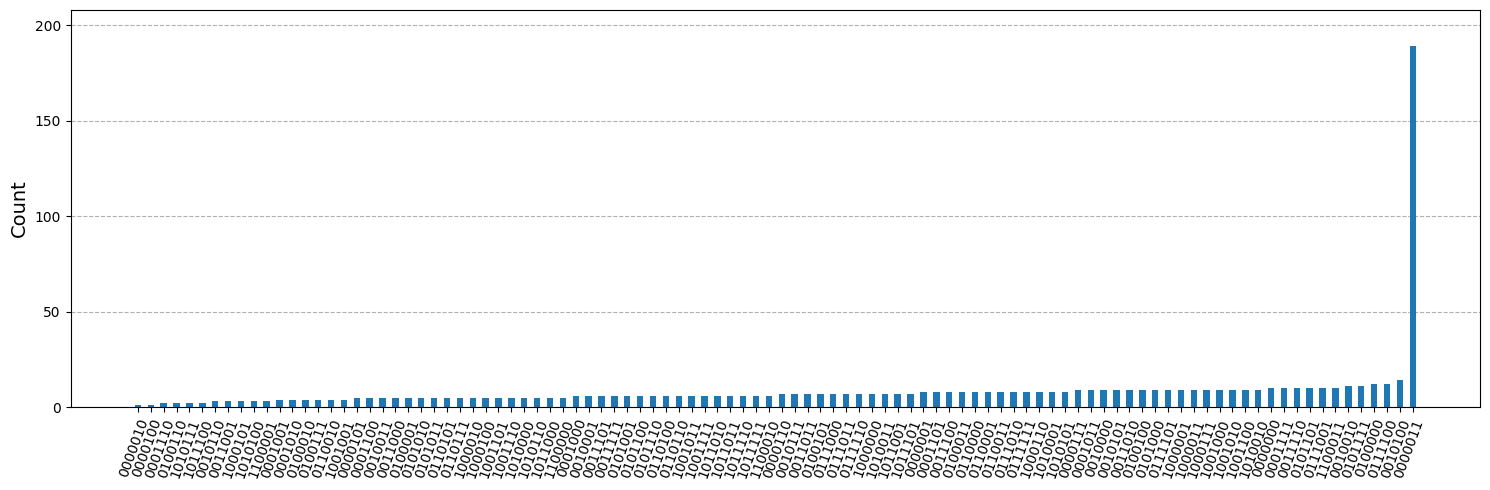

In [58]:
'''
Plot results
1. Sort results
2. Plot subset so it fits on figure
'''
#Sort by number of counts
sorted_counts_value = {k: v for k, v in sorted(counts.items(), key=lambda item: -item[1])}

#Sort by bit string
sorted_counts_key = {k: counts[k] for k in sorted(counts.keys())}

#Just plot a subset (NOTE: Amplitudes overestimated due to many truncated states)
first_n_results = 100
# plot_histogram(dict(list(sorted_counts_value.items())[:first_n_results])) # Plot results (slow with many qubits)
plot_histogram(dict(list(sorted_counts_key.items())[:first_n_results]),sort='value',bar_labels=False, figsize=(15,5)) # Plot results (slow with many qubits)

NOTE: only a handful of counts for the correct answer out of the 1000 trials!!
Many one shot errors in other states!

Use the 'most_frequent()' method to get what that result is:

In [59]:
#Get the most likely measured result from the counts
answer = counts.most_frequent()
print( 'Most frequent measured bit string = ' , answer)
print( 'Most frequent measured integer = ' ,int(answer,2))

#What was the desired solution again?
print( '\nDesired solution = ' , desired_solution)

print('\nTotal counts of most frequent result = ' , counts[answer] )
print('Total shots = ' , n_shots)
print('Probability of getting answer = ' , round(counts[answer]/n_shots *100,2) ,'%')


Most frequent measured bit string =  0000011
Most frequent measured integer =  3

Desired solution =  3

Total counts of most frequent result =  189
Total shots =  1024
Probability of getting answer =  18.46 %


Now we see that the correct answer has only a 1% chance of being measured. Still, with enough shots this is more likely than all of the other states and enough to determine the solution. And we can usually 'check' the answer quite easily.

# Conclusion

Now that we have seen the essence of the Grover search we can move beyond the trivial Oracle we setup for the example. The main utility of a Grover search is when an Oracle is constructed that allows you to ask a question. This question can be a logical check. If qubit 1 then qubit 2 etc etc.

To see how this is created the main exercise for this lab will be following the Qiskit tutorial on a 2x2 Binary Sudoku puzzle.

https://qiskit.org/textbook/ch-algorithms/grover.html#5.-Solving-Sudoku-using-Grover's-Algorithm-

This is a very nice example in that it only requires encoding the Sudoku board in single qubits (binary encoding) and the logical checks allow multiple solutions. This is very interesting too. Multiple solutions can be tried simultaneously using Grover search and multiple solutions can be found.

That is, the state |w⟩ we are looking for is not necessarily a single qubit configuration, it could be many.

The 'Queens problem' (a chess problem) allows a similar encoding and a similar problem type but for larger arrays. Again multiple solutions (configurations) of queens on the chessboard can be checked with an appropriate oracle.

>see: https://en.wikipedia.org/wiki/Eight_queens_puzzle


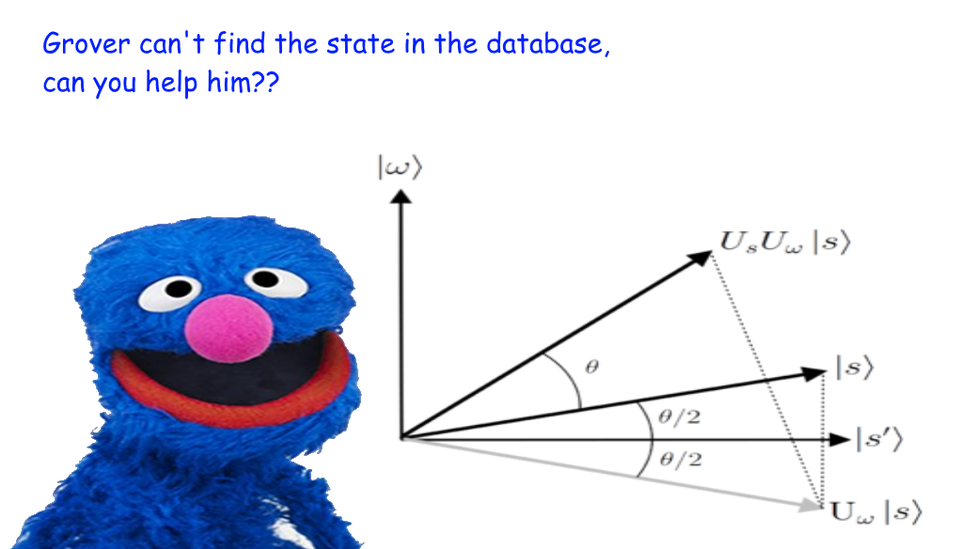

# Further reading:

IBM Qiskit tutorial
* https://qiskit.org/textbook/ch-algorithms/grover.html#3qubits

Amplitude amplification is also in Thomas Wong's textbook

* http://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e2p.pdf

Ion trap Experiment of 3 qubit Grover search
* 'Complete 3-Qubit Grover Search on a Programmable Quantum Computer' -  https://arxiv.org/abs/1703.10535



# Homework 10 (due 4/23)

1. Create a new notebook just for the problem set
1. Work with a partner or group of three to solve the problems
1. Summarize your results in a short report and upload to gradescope
1. Include a link to your colab notebook code 
1. Make sure the link gives 'General access' for 'Anyone with the link' to comment (and view)

___


## Problems


1. Decompose the Multi-control-Phase gate for 5 qubits. How many 2 qubit gates are needed? Plot the number of two qubit gates vs qubits in the register up to 10 qubits. How does it scale?

2. Add an additional solution to the Oracle so there are two possible solutions. Show the result. How many iterations does it take now to get the best result? Why would the number of iterations change?

  3. a) Use a Grover Search to solve a Sudoku Puzzle (2x2 binary puzzle) following this tutorial and show the answers.

  https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb


  3. b) What is the Oracle? Draw the Oracle circuit and plot the Oracle Matrix.


